### <center>    San Jose State University<br>Department of Applied Data Science</center>
##  <center>    DATA 245 Sec 21<br>Machine Learning Technologies 
###  <center>   Group 4: Vani Bhat




## **Credit Card Fraud Detection**


In [1]:
# Required installations
# !pip install imbalanced-learn
# !pip install sklearn
# !pip install haversine

In [2]:
# importing the required libraries
import pandas as pd
import glob
from pandas.plotting import scatter_matrix
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re 
import os
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## I. Business Understanding

* The objective of this project is to detect fraudulent credit card transactions and discuss how such frauds can be handled by employing various Machine Learning algorithms.
* Credit card usage has increased tremendously over the decade which revolutionized the cashless payment methods, but it comes with its own set of risks.
* To tackle this issue, we plan to employ Machine Learning models like Logistic Regression, Naive Bayes, KNN, Random Forest, XG Boost, SVM, and deep learning model. We will compare the performance of each model to identify the best fitting model which can help reduce fraudulent transactions. 

## II. Data Understanding

#### II.a. Collect and Store Dataset

- The synthetic data for credit card transactions for 1,000 customers is generated using the Sparkov_Data_Generation-master.
- All the transactions are created for the duration January 1, 2020 to December 31, 2021.
- The generator creates a csv file for each customer will all transactions for the given customer for the given time span.
- We will take the union of all the transactions in these csv files and load in the dataframe for our analysis. 
- The data collected from the generator is collated and stored in 'Concat.csv' on the google drive. Refer to Data_Collection_Sparkov.pynb for data generation and collation. 

In [ ]:
# Mounting the Google drive to get access in Google Colab. This step is not required if using Jupyter Notebook
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
# Loading the dataset
df = pd.read_csv(r"C:\Users\Revathi P\Documents\Sem 2\DATA_245\Project\dataset\Concat\Concat.csv", index_col = 0)
df.head(2)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,5c15602a5cf809764ed5d149a78e279a,2021-04-29,00:07:35,1.619680e+09,gas_transport,6.73,1.0,"fraud_Jenkins, Hauck and Friesen",44.084527,-67.954129
1,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,549fffa7671e25c7a183f2952ccff999,2021-04-29,07:10:46,1.619705e+09,gas_transport,12.74,1.0,"fraud_Zieme, Bode and Dooley",45.584705,-67.692301


#### II.b. 3 V (Volume, Variety, Velocity) of the data

In [4]:
# Volume: To print the number of rows and columns in the dataset
df.shape

(1752721, 26)

In [5]:
# Variety: Printing the information in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1752721 entries, 0 to 1752720
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   street      object 
 6   city        object 
 7   state       object 
 8   zip         int64  
 9   lat         float64
 10  long        float64
 11  city_pop    int64  
 12  job         object 
 13  dob         object 
 14  acct_num    int64  
 15  profile     object 
 16  trans_num   object 
 17  trans_date  object 
 18  trans_time  object 
 19  unix_time   float64
 20  category    object 
 21  amt         float64
 22  is_fraud    float64
 23  merchant    object 
 24  merch_lat   float64
 25  merch_long  float64
dtypes: float64(7), int64(4), object(15)
memory usage: 361.0+ MB


In [6]:
# Printing the descriptive statistics for the dataset
df.describe()

,cc_num,zip,lat,long,city_pop,acct_num,unix_time,amt,is_fraud,merch_lat,merch_long
count,1.752721e+06,1.752721e+06,1.752721e+06,1.752721e+06,1.752721e+06,1.752721e+06,1.751721e+06,1.751721e+06,1.751721e+06,1.751721e+06,1.751721e+06
mean,3.843047e+17,5.121929e+04,3.755229e+01,-9.171316e+01,3.154471e+05,4.987205e+11,1.611112e+09,7.051059e+01,5.314773e-03,3.755235e+01,-9.171333e+01
std,1.257718e+18,2.977578e+04,5.158298e+00,1.640430e+01,6.226473e+05,2.859440e+11,1.822508e+07,1.666364e+02,7.270852e-02,5.190740e+00,1.641442e+01
min,6.040616e+10,1.040000e+03,2.132950e+01,-1.593448e+02,1.760000e+02,2.348758e+09,1.577866e+09,1.000000e+00,0.000000e+00,2.032995e+01,-1.603443e+02
25%,1.800159e+14,2.729200e+04,3.387960e+01,-9.862490e+01,1.924000e+04,2.720987e+11,1.595429e+09,9.020000e+00,0.000000e+00,3.383905e+01,-9.865916e+01
50%,3.516698e+15,4.830900e+04,3.861910e+01,-8.662130e+01,6.016300e+04,4.956758e+11,1.609552e+09,4.385000e+01,0.000000e+00,3.848595e+01,-8.652043e+01
75%,4.514627e+15,7.770700e+04,4.150220e+01,-7.953990e+01,2.141120e+05,7.408025e+11,1.627089e+09,8.126000e+01,0.000000e+00,4.150950e+01,-7.944400e+01
max,4.986227e+18,9.950700e+04,6.115350e+01,-6.775340e+01,2.906700e+06,9.993899e+11,1.641024e+09,2.205483e+04,1.000000e+00,6.215252e+01,-6.675340e+01


In [7]:
# Velocity: We have generated the synthetic data once using the Sparkov Generator. This is a static one-time generated data.

#### II.c. Creating new calculated fields required for the analysis

1. Getting the area( urban/rural) from profile feature
2. Creating a new column with age calculated from the dob feature
3. Calculating distance between customer location and merchant location using latitude and longitude features
4. Extracting date and time from trans_date and trans_time features


In [8]:
# 1. Getting the area( urban/rural) from profile
df['area'] = df['profile'].str[-10 : -5]
df.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,area
0,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,00:07:35,1.619680e+09,gas_transport,6.73,1.0,"fraud_Jenkins, Hauck and Friesen",44.084527,-67.954129,rural
1,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,07:10:46,1.619705e+09,gas_transport,12.74,1.0,"fraud_Zieme, Bode and Dooley",45.584705,-67.692301,rural
2,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,10:09:12,1.619716e+09,gas_transport,9.53,1.0,fraud_Kling Inc,45.380492,-67.385962,rural
3,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,09:15:39,1.619713e+09,grocery_pos,10.95,1.0,fraud_Miller-Hauck,45.350439,-67.644179,rural
4,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,00:22:42,1.619681e+09,grocery_pos,353.18,1.0,fraud_McDermott-Weimann,45.424536,-67.852445,rural


In [9]:
# 2. Creating a new column with age calculated from the dob
now = datetime.datetime.now()
df['age'] = df.dob.apply(lambda x: now.year - datetime.datetime.strptime(x,'%Y-%m-%d').year )

In [10]:
# 3. Calculating distance between customer location and merchant location
lon1 = df["long"].astype(float)
lat1 = df["lat"].astype(float)
lon2 = df["merch_long"].astype(float)
lat2 = df["merch_lat"].astype(float)

In [11]:
# Defining the haversine_array function
def haversine_array(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    miles = round((3958 * dist),3) #6367 for distance in KM for miles use 3958
    return miles

df['distance'] = haversine_array(df['lat'], df['long'],df['merch_lat'], df['merch_long'])

In [12]:
# 4. Extracting date and time from trans_date, trans_time
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['trans_time'] = pd.to_datetime(df['trans_time'],format='%H:%M:%S')
df['month'] = df['trans_date'].dt.month.astype('Int64')
df['is_weekend'] = df.trans_date.dt.day_of_week.apply(lambda x: 1 if (x in [5,6]) else 0)
df['hour'] = df['trans_time'].dt.hour.astype('Int64')

In [14]:
# 5. Identifying the holiday months (November, December)
def month_categ(x):
    try:
        if (x==11) or (x==12):
          return 1
        else: return 2
    except Exception as err: pass

In [15]:
df['hol_month']=df['month'].apply(month_categ)

In [16]:
# 6. Fetching the shopping frequency
df.sort_values(by=['ssn','trans_date'],inplace=True,ascending=[True,False])
df['recent_shop']=df.groupby(['ssn'])['trans_date'].shift()
df['recent_shop_gap']=df['trans_date']-df['recent_shop']
df['recent_shop_gap']=df['recent_shop_gap'].astype('str')
# Getting customers who have recently shopped
def shop_category(x):
    if x =='0 days':
        return 'recent'
    else: 
        return 'past'
df['recent_shopper']=df['recent_shop_gap'].apply(shop_category)


In [17]:
# 7. Identifying locations which are suspicious to fraud 
# Flagging latitude based on how suspicious they are
def lat_long_category(x):
    if x <=8:
        return 1 #non-suspicious
    elif x <= 12:
        return 2 #mod-suspicious
    else: 
        return 3 #suspicious

df['lat_long']=df['lat']+df['long']
df_inter=df.groupby(['lat_long'])['is_fraud'].sum().reset_index().sort_values(by='is_fraud',ascending=False)
df_inter['lat_long_type']=df_inter['is_fraud'].apply(lat_long_category)
df=pd.merge(df,df_inter[['lat_long','lat_long_type']],how='inner',on='lat_long')

In [18]:
# 8. Identifying the categories with high prevalance of fradulent incidents 
def genuine_categ(x):
    if x <=186:
        return 1
    elif x <= 1008:
        return 2
    else:
        return 3

df_categ_inter=df.groupby(['category'])['is_fraud'].sum().reset_index(name='category_fraud').sort_values(by='category_fraud',ascending=False)
df_categ_inter['categ_type']=df_categ_inter['category_fraud'].apply(genuine_categ)
df=pd.merge(df,df_categ_inter[['category','categ_type']],how='inner',on='category')

In [19]:
# 9. Clubbing times of the day
def hour_categ(x):
    if (x==22) or (x==23) or ((x>=0) and (x<=3)):
        return 'midnight'
    else:
        return 'daylight'
df['hour_type']=df['hour'].apply(hour_categ)

In [20]:
# Verifying the newly created features
df.head(2)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,is_weekend,hour,hol_month,recent_shop,recent_shop_gap,recent_shopper,lat_long,lat_long_type,categ_type,hour_type
0,001-28-0753,4661995305641840,Pamela,Lee,F,467 Wayne Neck Apt. 187,Beverly,MA,1915,42.5608,...,0,23,1.0,NaT,NaT,past,-28.3151,1,3,midnight
1,001-28-0753,4661995305641840,Pamela,Lee,F,467 Wayne Neck Apt. 187,Beverly,MA,1915,42.5608,...,0,12,1.0,2021-11-16,0 days,recent,-28.3151,1,3,daylight


In [21]:
# df_org = df.copy()
df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long', 'area', 'age',
       'distance', 'month', 'is_weekend', 'hour', 'hol_month', 'recent_shop',
       'recent_shop_gap', 'recent_shopper', 'lat_long', 'lat_long_type',
       'categ_type', 'hour_type'],
      dtype='object')

#### II.d. Exploratory Data Analysis (EDA)

In [22]:
# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

ssn: False
cc_num: False
first: False
last: False
gender: False
street: False
city: False
state: False
zip: False
lat: False
long: False
city_pop: False
job: False
dob: False
acct_num: False
profile: False
trans_num: False
trans_date: False
trans_time: False
unix_time: False
category: False
amt: False
is_fraud: False
merchant: False
merch_lat: False
merch_long: False
area: False
age: False
distance: False
month: False
is_weekend: False
hour: False
hol_month: False
recent_shop: True
recent_shop_gap: False
recent_shopper: False
lat_long: False
lat_long_type: False
categ_type: False
hour_type: False


- We see that there are multiple columns with missing values in the dataset. We will handle these in the data preparation stage
- We see that there are 9,310 instances of fraudulent transactions

0.0    1742411
1.0       9310
Name: is_fraud, dtype: int64



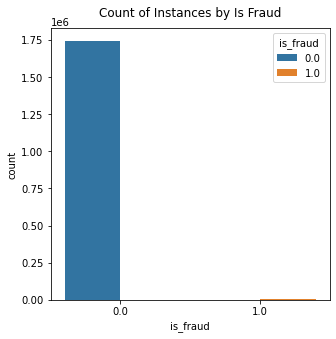

In [23]:
# Printing the target feature distribution in the dataset
print(df.is_fraud.value_counts())
print()
plt.figure(figsize = (5,5))
plt.title("Count of Instances by Is Fraud", y=1.02)
sns.countplot(x=df.is_fraud, data = df,hue = df.is_fraud)
plt.show()

- We see that the number of non-fraudulent transactions(99.5%) is higher as compared to the fradulent transactions(0.5%). Therefore, this is an imbalanced dataset. We will perform various sampling methods on our dataset in the following sections.

In [24]:
# df = df_org
df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long', 'area', 'age',
       'distance', 'month', 'is_weekend', 'hour', 'hol_month', 'recent_shop',
       'recent_shop_gap', 'recent_shopper', 'lat_long', 'lat_long_type',
       'categ_type', 'hour_type'],
      dtype='object')

In [25]:
# Drop the columns that are not necessary for the model development
df=df[['gender','city_pop','amt','is_fraud','area','age','distance','hol_month','is_weekend','hour_type','recent_shopper',\
   'lat_long_type','categ_type']]

In [26]:
# Printing the columns used in modeling
df.columns

Index(['gender', 'city_pop', 'amt', 'is_fraud', 'area', 'age', 'distance',
       'hol_month', 'is_weekend', 'hour_type', 'recent_shopper',
       'lat_long_type', 'categ_type'],
      dtype='object')

### Data Quality Report for Continuous Features

In [27]:
# Creating a dataframe with continuous attributes in the data table
df_cont = df[['city_pop','amt', 'age', 'distance']].copy()
df_cont.head()

,city_pop,amt,age,distance
0,39502,317.35,95,25.136
1,39502,880.85,95,7.231
2,39502,962.98,95,14.856
3,8399,816.18,57,35.963
4,8399,1034.97,57,45.031


In [28]:
# Datatypes of continuous features
df_cont.dtypes

city_pop      int64
amt         float64
age           int64
distance    float64
dtype: object

In [29]:
# Converting the data type of 'city_pop' feature to float
df_cont.city_pop = df_cont['city_pop'].astype(float)

In [30]:
# Computing the fields for the Data Quality Report
data_types = pd.DataFrame(df_cont.dtypes,
                          columns=['Data Type'])

total_count = pd.DataFrame(df_cont.count(),
                                   columns=['Count'])

percentage_missing = pd.DataFrame(df_cont.isnull().sum()/len(df)*100,
                                   columns=['%Miss'])

cardinality = pd.DataFrame(columns=['Cardinality'])
for v in list(df_cont.columns.values):
    cardinality.loc[v] = [df_cont[v].nunique()]
    
minimum = pd.DataFrame(columns=['Min'])
for v in list(df_cont.columns.values):
    minimum.loc[v] = [df_cont[v].min()]
    
first_quartile = pd.DataFrame(columns=['1st Qrt'])
for v in list(df_cont.columns.values):
    first_quartile.loc[v] = [df_cont[v].quantile(0.25)]
    
mean = pd.DataFrame(columns=['Mean'])
for v in list(df_cont.columns.values):
    mean.loc[v] = [df_cont[v].mean()]
    
median = pd.DataFrame(columns=['Median'])
for v in list(df_cont.columns.values):
    median.loc[v] = [df_cont[v].median()]
    
third_quartile = pd.DataFrame(columns=['3rd Qrt'])
for v in list(df_cont.columns.values):
    third_quartile.loc[v] = [df_cont[v].quantile(0.75)]
    
maximum = pd.DataFrame(columns=['Max'])
for v in list(df_cont.columns.values):
    maximum.loc[v] = [df_cont[v].max()]
    
stddev = pd.DataFrame(columns=['Std_Dev'])
for v in list(df_cont.columns.values):
    stddev.loc[v] = [df_cont[v].std()]

In [31]:
# Concatinating the fields for the Data Quality Report
data_quality_report = data_types.join(total_count).join(percentage_missing).join(cardinality).join(minimum).join(first_quartile).join(mean).join(median).join(third_quartile).join(maximum).join(stddev)
print("\nData Quality Report")
print("Total records: {}".format(len(data_quality_report.index)))
data_quality_report.round(2)


Data Quality Report
Total records: 4


,Data Type,Count,%Miss,Cardinality,Min,1st Qrt,Mean,Median,3rd Qrt,Max,Std_Dev
city_pop,float64,1751721,0.0,798,176.00,19240.00,315454.76,60163.00,214112.00,2906700.00,622657.87
amt,float64,1751721,0.0,60327,1.00,9.02,70.51,43.85,81.26,22054.83,166.64
age,int64,1751721,0.0,81,15.00,31.00,44.66,43.00,56.00,96.00,17.43
distance,float64,1751721,0.0,75368,0.02,20.53,36.69,36.44,53.03,92.98,19.08


In [32]:
# Plotting the correlation matrix for the continuous features in the dataset
df_correlation = df.corr(method = 'pearson')
df_correlation

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type
city_pop,1.000000,-0.000740,-0.001707,0.023788,-0.004023,-0.000164,-0.002783,-0.005458,-0.001210
amt,-0.000740,1.000000,0.207886,0.006935,-0.000236,0.013112,-0.003336,-0.006448,0.024179
is_fraud,-0.001707,0.207886,1.000000,0.021538,-0.000451,0.009501,-0.014363,0.015112,0.057179
age,0.023788,0.006935,0.021538,1.000000,-0.001763,-0.000371,-0.017083,-0.085162,0.006088
distance,-0.004023,-0.000236,-0.000451,-0.001763,1.000000,0.000613,-0.001359,-0.002281,0.000553
hol_month,-0.000164,0.013112,0.009501,-0.000371,0.000613,1.000000,0.024383,0.000905,-0.160897
is_weekend,-0.002783,-0.003336,-0.014363,-0.017083,-0.001359,0.024383,1.000000,0.011089,-0.001180
lat_long_type,-0.005458,-0.006448,0.015112,-0.085162,-0.002281,0.000905,0.011089,1.000000,-0.003017
categ_type,-0.001210,0.024179,0.057179,0.006088,0.000553,-0.160897,-0.001180,-0.003017,1.000000


<AxesSubplot:>

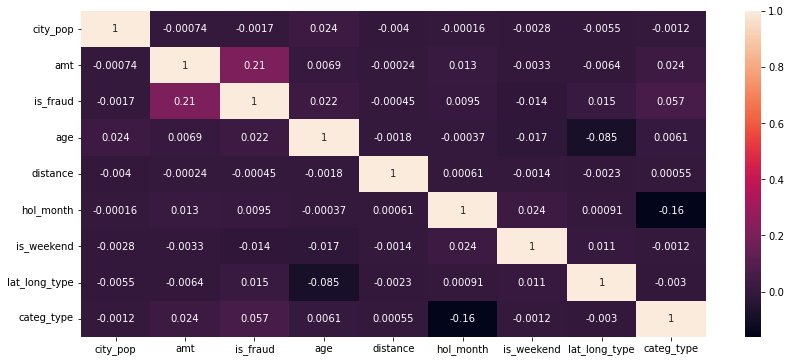

In [33]:
import seaborn as sns
%matplotlib inline
# Plotting the correlation matrix for the continuous features in the dataset
# plot the heatmap
fig, ax = plt.subplots(figsize=(14,6)) 
sns.heatmap(df_correlation,annot=True, 
        xticklabels=df_correlation.columns,
        yticklabels=df_correlation.columns)

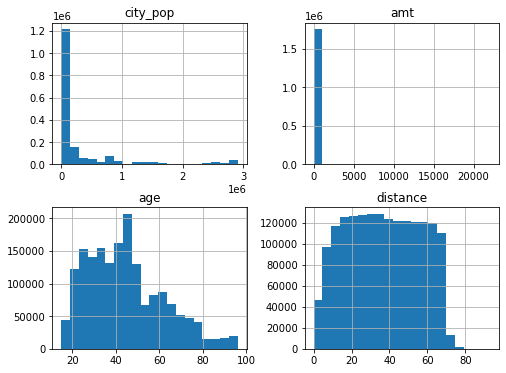

In [34]:
# Plotting the histograms for the continuous attributes in the dataset 
%matplotlib inline 

df_cont.hist(bins=20, figsize = (8,6))
plt.show()


<AxesSubplot:>

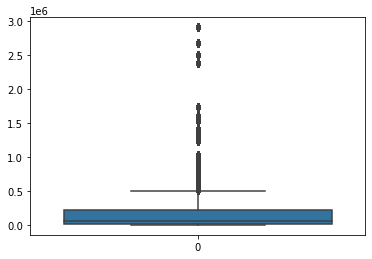

In [35]:
sns.boxplot(data = df_cont['city_pop'])

<AxesSubplot:>

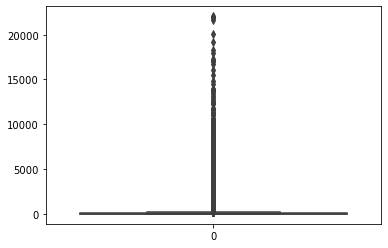

In [36]:
sns.boxplot(data = df_cont['amt'])

<AxesSubplot:>

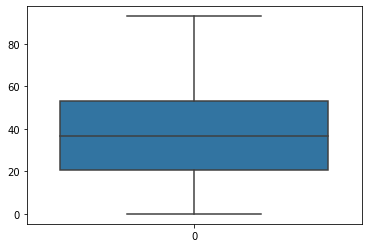

In [37]:
sns.boxplot(data = df_cont['distance'])

<AxesSubplot:>

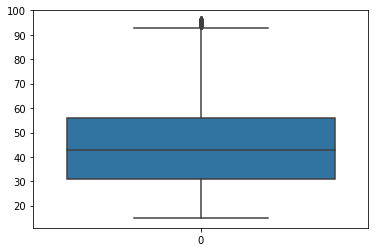

In [38]:
sns.boxplot(data = df_cont['age'])

### Data Quality Report for Categorical Features

In [39]:
# Creating a dataframe with categorical features in the data table
df_categ = df[['gender', 'is_fraud', 'area', 'hol_month', 'is_weekend', 'hour_type', 'recent_shopper', 'lat_long_type', 'categ_type']].copy()
df_categ.head()

,gender,is_fraud,area,hol_month,is_weekend,hour_type,recent_shopper,lat_long_type,categ_type
0,F,1.0,urban,1.0,0,midnight,past,1,3
1,F,1.0,urban,1.0,0,daylight,recent,1,3
2,F,1.0,urban,1.0,0,midnight,recent,1,3
3,F,1.0,urban,2.0,0,midnight,recent,2,3
4,F,1.0,urban,2.0,0,daylight,recent,2,3


In [40]:
# Printing the information of the categorical features
df_categ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751721 entries, 0 to 1751720
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   gender          object 
 1   is_fraud        float64
 2   area            object 
 3   hol_month       float64
 4   is_weekend      int64  
 5   hour_type       object 
 6   recent_shopper  object 
 7   lat_long_type   int64  
 8   categ_type      int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 133.6+ MB


In [41]:
# Converting the data type of the features to string
df_categ = df_categ.astype(str)

In [42]:
# Computing the fields for the Data Quality Report
data_types = pd.DataFrame(df_categ.dtypes,
                          columns=['Data Type'])

total_count = pd.DataFrame(df_categ.count(),
                                   columns=['Count'])

percentage_missing = pd.DataFrame(df_categ.isnull().sum()/len(df)*100,
                                   columns=['%Miss'])

cardinality = pd.DataFrame(columns=['Cardinality'])
for v in list(df_categ.columns.values):
    cardinality.loc[v] = [df_categ[v].nunique()]
    
mode = pd.DataFrame(columns=['Mode'])
for v in list(df_categ.columns.values):
    mode.loc[v] = [df_categ[v].value_counts().index.tolist()[0]]
    
mode_freq = pd.DataFrame(columns=['Mode Freq'])
for v in list(df_categ.columns.values):
    mode_freq.loc[v] = [df_categ[v].value_counts()[0]]

mode_perc = pd.DataFrame(columns=['Mode Perc'])
for v in list(df_categ.columns.values):
    mode_perc.loc[v] = [df_categ[v].value_counts()[0]/len(df_categ['gender'])*100]    
    
smode = pd.DataFrame(columns=['Second Mode'])
for v in list(df_categ.columns.values):
    smode.loc[v] = [df_categ[v].value_counts().index.tolist()[1]]
    
smode_freq = pd.DataFrame(columns=['Second Mode Freq'])
for v in list(df_categ.columns.values):
    smode_freq.loc[v] = [df_categ[v].value_counts()[1]]

smode_perc = pd.DataFrame(columns=['Second Mode Perc'])
for v in list(df_categ.columns.values):
    smode_perc.loc[v] = [df_categ[v].value_counts()[1]/len(df_categ['gender'])*100]  

In [43]:
# Concatinating the fields in the Data Quality Report
data_quality_report2 = data_types.join(total_count).join(percentage_missing).join(cardinality).join(mode).join(mode_freq).join(mode_perc).join(smode).join(smode_freq).join(smode_perc)
print("\nData Quality Report - Categorical Features")
print("Total records: {}".format(len(data_quality_report2.index)))
data_quality_report2


Data Quality Report - Categorical Features
Total records: 9


,Data Type,Count,%Miss,Cardinality,Mode,Mode Freq,Mode Perc,Second Mode,Second Mode Freq,Second Mode Perc
gender,object,1751721,0.0,2,M,895503,51.121326,F,856218,48.878674
is_fraud,object,1751721,0.0,2,0.0,1742411,99.468523,1.0,9310,0.531477
area,object,1751721,0.0,2,urban,1680714,95.946444,rural,71007,4.053556
hol_month,object,1751721,0.0,2,2.0,1358082,77.528442,1.0,393639,22.471558
is_weekend,object,1751721,0.0,2,0,1055304,60.243840,1,696417,39.756160
hour_type,object,1751721,0.0,2,daylight,1342626,76.646110,midnight,409095,23.353890
recent_shopper,object,1751721,0.0,2,recent,1218395,69.554170,past,533326,30.445830
lat_long_type,object,1751721,0.0,3,2,810978,46.296071,1,637355,36.384504
categ_type,object,1751721,0.0,3,2,833343,47.572816,3,546081,31.173971


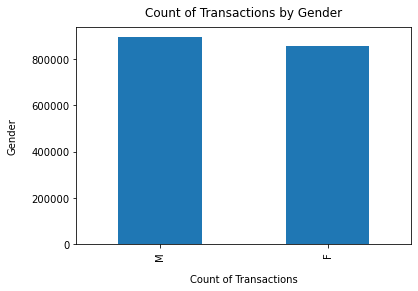

In [44]:
df.gender.value_counts().plot(kind="bar")
plt.xlabel("Count of Transactions", labelpad=14)
plt.ylabel("Gender", labelpad=14)
plt.title("Count of Transactions by Gender", y=1.02);

<AxesSubplot:>

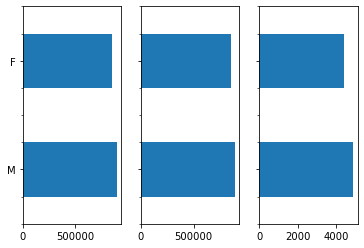

In [45]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
df.gender.value_counts().plot(kind="barh", ax = ax1)
df[df.is_fraud == 0].gender.value_counts().plot(kind="barh", ax = ax2)
df[df.is_fraud == 1].gender.value_counts().plot(kind="barh", ax = ax3)

<AxesSubplot:>

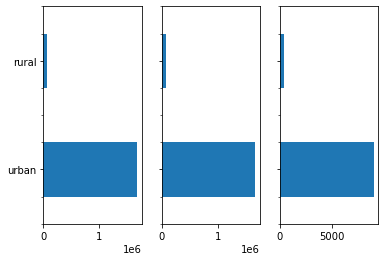

In [46]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
df.area.value_counts().plot(kind="barh", ax = ax1)
df[df.is_fraud == 0].area.value_counts().plot(kind="barh", ax = ax2)
df[df.is_fraud == 1].area.value_counts().plot(kind="barh", ax = ax3)

<AxesSubplot:>

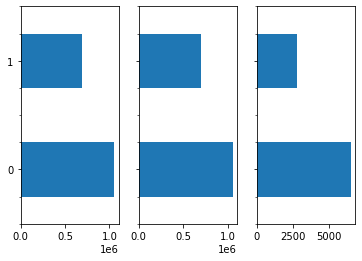

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
df.is_weekend.value_counts().plot(kind="barh", ax = ax1)
df[df.is_fraud == 0].is_weekend.value_counts().plot(kind="barh", ax = ax2)
df[df.is_fraud == 1].is_weekend.value_counts().plot(kind="barh", ax = ax3)

## III. Data Preparation

### III.a. Data Cleaning

In [48]:
# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

gender: False
city_pop: False
amt: False
is_fraud: False
area: False
age: False
distance: False
hol_month: False
is_weekend: False
hour_type: False
recent_shopper: False
lat_long_type: False
categ_type: False


In [49]:
# Drop the instances have all null values present in the dataset
df.dropna(axis = 0, how='all', inplace = True)

# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

gender: False
city_pop: False
amt: False
is_fraud: False
area: False
age: False
distance: False
hol_month: False
is_weekend: False
hour_type: False
recent_shopper: False
lat_long_type: False
categ_type: False


In [50]:
# Removing the entries where the target feature is not available as this is required for our modeling
df.dropna(axis = 0, how='any', inplace = True) # Considered for all instances having null values in either features

In [51]:
# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

gender: False
city_pop: False
amt: False
is_fraud: False
area: False
age: False
distance: False
hol_month: False
is_weekend: False
hour_type: False
recent_shopper: False
lat_long_type: False
categ_type: False


- All the missing value fields are eliminated from the dataframe

In [52]:
# Check for duplicates
df.duplicated().value_counts()

False    1751721
dtype: int64

- Here we see there are no duplicate instances in the dataset

#### III.c. Feature Engineering

- The dataset consists of many categorical features. However, many of the machine learning models usually require numerical values as the input. Hence, necessary transformatin of data from categorical to numerical is must.In this section, we take multiple measures to convert data to make it suitable for modelling.

In [53]:
#Below are the different features in the dataset
df.columns

Index(['gender', 'city_pop', 'amt', 'is_fraud', 'area', 'age', 'distance',
       'hol_month', 'is_weekend', 'hour_type', 'recent_shopper',
       'lat_long_type', 'categ_type'],
      dtype='object')

In [54]:
# sample dataframe after dropping unnecessary columns
df.head()

,gender,city_pop,amt,is_fraud,area,age,distance,hol_month,is_weekend,hour_type,recent_shopper,lat_long_type,categ_type
0,F,39502,317.35,1.0,urban,95,25.136,1.0,0,midnight,past,1,3
1,F,39502,880.85,1.0,urban,95,7.231,1.0,0,daylight,recent,1,3
2,F,39502,962.98,1.0,urban,95,14.856,1.0,0,midnight,recent,1,3
3,F,8399,816.18,1.0,urban,57,35.963,2.0,0,midnight,recent,2,3
4,F,8399,1034.97,1.0,urban,57,45.031,2.0,0,daylight,recent,2,3


In [55]:
# Label Encoding
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

df['categ_type']=label_encoder.fit_transform(df['categ_type'])
df['lat_long_type']=label_encoder.fit_transform(df['lat_long_type'])

In [56]:
df.columns

Index(['gender', 'city_pop', 'amt', 'is_fraud', 'area', 'age', 'distance',
       'hol_month', 'is_weekend', 'hour_type', 'recent_shopper',
       'lat_long_type', 'categ_type'],
      dtype='object')

In [57]:
# Finding dependency with the target variable using chi-squared test statistics
cols=['gender','area','hol_month','is_weekend','hour_type','recent_shopper','lat_long_type','categ_type']
for i in df[cols]:
    data_interim=df[[i, 'is_fraud']]

    data_cont=pd.crosstab(data_interim[i],data_interim['is_fraud'])

    from scipy.stats import chi2_contingency
    stat, p, dof, expected = chi2_contingency(data_cont)

    #-----------interpret p-value
    alpha = 0.05
    print(i,p,p<alpha)

gender 0.011816646789754925 True
area 0.9952116981974969 False
hol_month 3.384267476615273e-36 True
is_weekend 1.711962979716311e-80 True
hour_type 0.0 True
recent_shopper 1.9626976385969158e-90 True
lat_long_type 4.8147231182969436e-111 True
categ_type 0.0 True


In [58]:
# One-hot Encoding 
df = pd.get_dummies(df, columns = ['gender', 'area','hour_type','recent_shopper'])

In [59]:
# Selecting only the valuable fields
df.drop(['gender_F','area_urban','hour_type_daylight','recent_shopper_past','area_urban','area_rural'],axis=1,inplace=True)

In [60]:
# sample dataframe after one hot encoding of gender and category variable
df.head(5)

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent
0,39502,317.35,1.0,95,25.136,1.0,0,0,2,0,1,0
1,39502,880.85,1.0,95,7.231,1.0,0,0,2,0,0,1
2,39502,962.98,1.0,95,14.856,1.0,0,0,2,0,1,1
3,8399,816.18,1.0,57,35.963,2.0,0,1,2,0,1,1
4,8399,1034.97,1.0,57,45.031,2.0,0,1,2,0,0,1


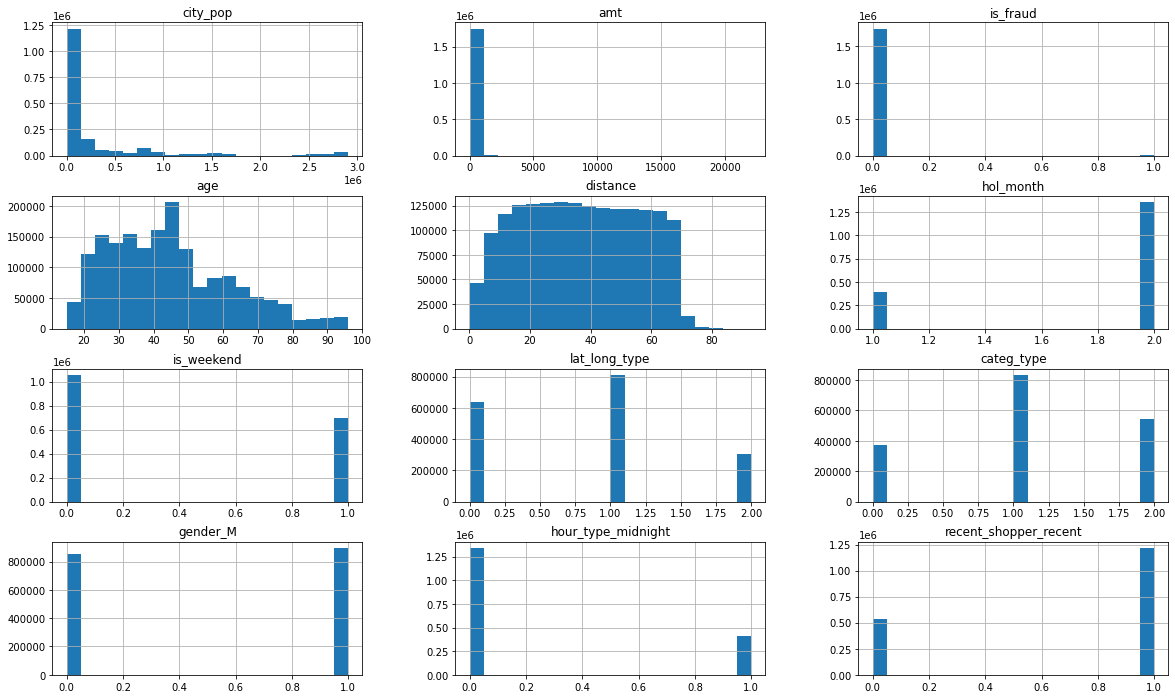

In [61]:
# Plotting the histograms for the continuous attributes in the dataset 
%matplotlib inline 

df.hist(bins=20, figsize = (20,12))
plt.show()

- From the above histogram, we can see that most of the distributions do not follow normal distribution

#### III.c  Data Scaling: Normalization

In [62]:
 ## We are doing range normalisation only for the fields which includes wide variety of values.

for col in df.columns:
    x = df[col].unique()

In [63]:
# Range normalisation

# apply normalization techniques
for column in df.columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# view normalized data
df.head()

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent
0,0.013530,0.014344,1.0,0.987654,0.270223,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.013530,0.039896,1.0,0.987654,0.077621,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.013530,0.043620,1.0,0.987654,0.159642,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.002829,0.036963,1.0,0.518519,0.386687,1.0,0.0,0.5,1.0,0.0,1.0,1.0
4,0.002829,0.046884,1.0,0.518519,0.484230,1.0,0.0,0.5,1.0,0.0,0.0,1.0


In [64]:
df=pd.read_csv(r"C:\Users\Revathi P\Documents\Sem 2\DATA_245\Project\dataset\Normalized_updated_features.csv")

In [65]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [66]:
df.head(2)

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent
0,0.01353,0.014344,1.0,0.987654,0.270223,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.01353,0.039896,1.0,0.987654,0.077621,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### III.d. Sampling

- As our data is imbalanced, we will be experimenting upsampling, downsampling, updownsampling, and SMOTE methods.

In [67]:
#separating fraud and non-fraud transaction
FraudDataset = df.loc[df['is_fraud'] == 1]
ValidDataset = df.loc[df['is_fraud'] == 0]

In [68]:
print('Count of fraudulent transations:', len(FraudDataset))
print('Count of non-fraudulent transations:', len(ValidDataset))

Count of fraudulent transations: 9310
Count of non-fraudulent transations: 1742411


In [69]:
#1) downsampling valid dataset to 9310 , total 18,620 records
#downsampling
from sklearn.utils import resample
valid_downsample = resample(ValidDataset,
             replace=True,
             n_samples= len(FraudDataset),
             random_state=42)

print(valid_downsample.shape)

(9310, 12)


In [70]:
#combining 2 datasets 
df2 = pd.concat([valid_downsample, FraudDataset])
print(df2['is_fraud'].value_counts())

0.0    9310
1.0    9310
Name: is_fraud, dtype: int64


<AxesSubplot:ylabel='Type'>

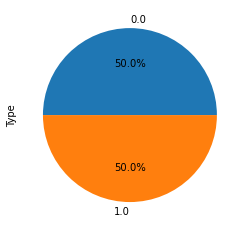

In [71]:
#plotting piechart after resampling
df2.groupby('is_fraud').size().plot(kind='pie',
                                       y = 'is_fraud',
                                       label = "Type",
                                       autopct='%1.1f%%')

In [72]:
X = df2.drop(labels='is_fraud', axis=1)
y = df2['is_fraud']
X.shape, y.shape

((18620, 11), (18620,))

In [73]:
#2)Upsampling fraud dataset to  17,42411 , total 3484822 records
# #upsampling
# from sklearn.utils import resample
# fraud_upsample = resample(FraudDataset,
#              replace=True,
#              n_samples=len(ValidDataset),
#              random_state=42)

# print(fraud_upsample.shape)

In [74]:
# #combining 2 datasets 
# df2 = pd.concat([fraud_upsample, ValidDataset])
# print(df2['is_fraud'].value_counts())

In [75]:
# #plotting piechart after resampling
# df2.groupby('is_fraud').size().plot(kind='pie',
#                                        y = 'is_fraud',
#                                        label = "Type",
#                                        autopct='%1.1f%%')

In [76]:
#3) upsampling and downsamplimg to some threhold  value say 50000
# #downsampling
# from sklearn.utils import resample
# valid_downsample = resample(ValidDataset,
#              replace=True,
#              n_samples= 50000,
#              random_state=42)

# print(valid_downsample.shape)

In [77]:
# #upsampling
# from sklearn.utils import resample
# fraud_upsample = resample(FraudDataset,
#              replace=True,
#              n_samples=len(valid_downsample),
#              random_state=42)

# print(fraud_upsample.shape)

In [78]:
# #combining 2 datasets 
# df2 = pd.concat([fraud_upsample, valid_downsample])
# print(df2['is_fraud'].value_counts())

In [79]:
# #plotting piechart after resampling
# df2.groupby('is_fraud').size().plot(kind='pie',
#                                        y = 'is_fraud',
#                                        label = "Type",
#                                        autopct='%1.1f%%')

In [80]:
#4) SMOTE - upsampling fraud dataset to 17,42411  - it might create noisy data by over sampling
# X = df.drop(labels='is_fraud', axis=1)
# y = df[['is_fraud']]

In [81]:
# su = SMOTE(random_state=42)

In [82]:
# su.fit_resample(X,y)

In [83]:
# X_su, y_su = su.fit_resample(X, y)

In [84]:
# #combining 2 datasets 
# df2 = pd.concat([X_su, y_su])
# print(df2['is_fraud'].value_counts())

In [85]:
# #plotting piechart after resampling
# y_su.groupby('is_fraud').size().plot(kind='pie',
#                                        y = 'is_fraud',
#                                        label = "Type",
#                                        autopct='%1.1f%%')

#### III.e. Split data into Training and Testing

In [86]:
# df = df.iloc[: , 1:]
# df.head(2)

In [87]:
# # assigning features to X and target to y

# X = df[['city', 'city_pop', 'job', 'category', 'amt', 'merchant',
#        'distance', 'year', 'month', 'day_of_month', 'is_weekend', 'hour',
#        'gender_F', 'gender_M', 'age_category_adult', 'age_category_senior',
#        'age_category_young', 'area_rural', 'area_urban']]

# y = df.is_fraud

In [88]:
# splitting the dataset into training and testing set

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y,train_size=.80,shuffle = True, random_state= 42)

print(f'Training dataset : {xtrain.shape} {ytrain.shape}') # dimension of train set
print(f'Testing dataset : {xtest.shape}, {ytest.shape}') # dimension of test set

Training dataset : (14896, 11) (14896,)
Testing dataset : (3724, 11), (3724,)


#### Dimentionality Reduction using PCA

In [89]:
# # Plotting scree plot to decide the number of principle components required
# # Experiment on whether standardization or normalization for PCA (mostly they use both, but need to read more)

# pca = PCA(n_components=10)

# #fit PCA model to data
# pca_fit = pca.fit(xtrain)

# PC_values = np.arange(pca.n_components_) + 1
# plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.show()

In [90]:
# # 4 components are selected based on observation from screeplot
# # This will consider 4 principle components from the dataframe which can further be used for modelling
# pca = PCA(n_components=4)
# X_train = pca.fit_transform(xtrain)
# X_test = pca.transform(xtest)

## IV. Modeling

In [91]:
# Random Forest

In [ ]:
# Normal

In [65]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(xtrain,ytrain)

y_pred=clf.predict(xtest)

In [66]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred, target_names=['non fraud','fraud']))

              precision    recall  f1-score   support

   non fraud       0.94      0.95      0.95      1862
       fraud       0.95      0.94      0.95      1862

    accuracy                           0.95      3724
   macro avg       0.95      0.95      0.95      3724
weighted avg       0.95      0.95      0.95      3724



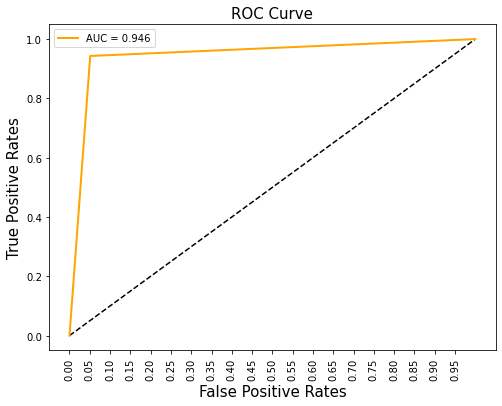

In [67]:
# Importing the required metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

#defining roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth=2, label=label,color='orange')
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    
    plt.show()

#plotting ROC curve
fpr, tpr, threshold = roc_curve(ytest, y_pred)
knn_auc = roc_auc_score(ytest, y_pred)
plot_roc_curve(fpr, tpr, 'AUC = %.3f' % knn_auc)


In [68]:
# Hyperparameter Tuning

In [86]:
# Using GridsearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

clf=RandomForestClassifier(n_estimators=100)
ss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)
params = [{'criterion':["gini","entropy"],"max_depth":[5,6,7,8,9,10,11,12],"class_weight":["balanced"],"random_state":[18]\
          ,"max_features":['sqrt','log2']}]
GSCV = GridSearchCV(clf,params,scoring="roc_auc",cv=ss)
GSCV.fit(xtrain,ytrain)
GSCV.best_params_
best_model = GSCV.best_estimator_

In [87]:
GSCV.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'sqrt',
 'random_state': 18}

In [88]:
from sklearn.metrics import roc_curve

preds = best_model.predict_proba(xtrain)[:,1]

fpr, tpr, thresholds = roc_curve(ytrain, preds)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (GSCV.predict_proba(xtest)[:,1] >= optimal_threshold).astype(bool)

In [89]:
optimal_threshold

0.5787892259366217

In [90]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred, target_names=['non fraud','fraud']))

              precision    recall  f1-score   support

   non fraud       0.93      0.96      0.94      1862
       fraud       0.96      0.92      0.94      1862

    accuracy                           0.94      3724
   macro avg       0.94      0.94      0.94      3724
weighted avg       0.94      0.94      0.94      3724



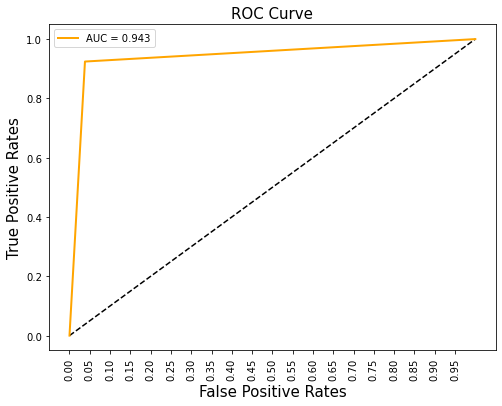

In [74]:
# Importing the required metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

#defining roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth=2, label=label,color='orange')
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    
    plt.show()

#plotting ROC curve
fpr, tpr, threshold = roc_curve(ytest, y_pred)
knn_auc = roc_auc_score(ytest, y_pred)
plot_roc_curve(fpr, tpr, 'AUC = %.3f' % knn_auc)


In [91]:
combined_df = pd.concat([xtest, ytest], axis=1) 
combined_df['ypred_best'] = y_pred.tolist()
combined_df.head()
combined_df.to_csv('rf_pred.csv')

In [75]:
# XGBoost
from xgboost import XGBClassifier
clf = XGBClassifier(booster='gbtree',n_estimators=100,random_state=0)
clf.fit(xtrain, ytrain)
y_pred=clf.predict(xtest)

In [76]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred, target_names=['non fraud','fraud']))

              precision    recall  f1-score   support

   non fraud       0.95      0.95      0.95      1862
       fraud       0.95      0.95      0.95      1862

    accuracy                           0.95      3724
   macro avg       0.95      0.95      0.95      3724
weighted avg       0.95      0.95      0.95      3724



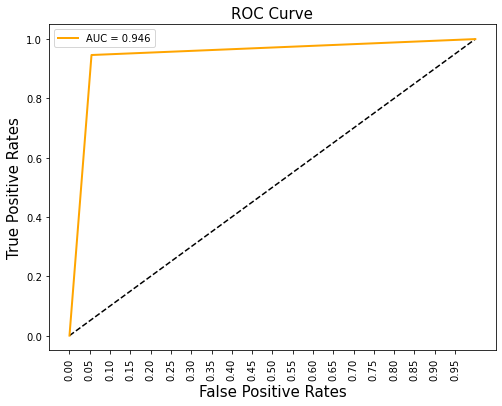

In [77]:
# Importing the required metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

#defining roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth=2, label=label,color='orange')
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    
    plt.show()

#plotting ROC curve
fpr, tpr, threshold = roc_curve(ytest, y_pred)
knn_auc = roc_auc_score(ytest, y_pred)
plot_roc_curve(fpr, tpr, 'AUC = %.3f' % knn_auc)

In [92]:
# Using GridsearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

ss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)
clf = XGBClassifier(booster='gbtree',n_estimators=100,random_state=0)
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
GSCV = GridSearchCV(clf,params,scoring="roc_auc",cv=ss)
GSCV.fit(xtrain,ytrain)
GSCV.best_params_
best_model = GSCV.best_estimator_

In [93]:
GSCV.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [95]:
from sklearn.metrics import roc_curve

preds = best_model.predict_proba(xtrain)[:,1]

fpr, tpr, thresholds = roc_curve(ytrain, preds)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (GSCV.predict_proba(xtest)[:,1] >= optimal_threshold).astype(bool)

In [96]:
optimal_threshold

0.47471753

In [97]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred, target_names=['non fraud','fraud']))

              precision    recall  f1-score   support

   non fraud       0.95      0.94      0.95      1862
       fraud       0.94      0.95      0.95      1862

    accuracy                           0.95      3724
   macro avg       0.95      0.95      0.95      3724
weighted avg       0.95      0.95      0.95      3724



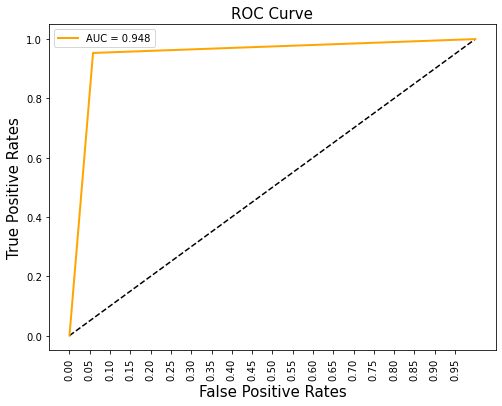

In [85]:
# Importing the required metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

#defining roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth=2, label=label,color='orange')
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    
    plt.show()

#plotting ROC curve
fpr, tpr, threshold = roc_curve(ytest, y_pred)
knn_auc = roc_auc_score(ytest, y_pred)
plot_roc_curve(fpr, tpr, 'AUC = %.3f' % knn_auc)

In [130]:
combined_df

,city_pop,amt,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent,is_fraud,ypred_best
436323,0.313079,0.000296,0.580247,0.552687,1.0,0.0,0.5,1.0,1.0,1.0,1.0,0.0,True
398140,0.011839,0.000248,0.074074,0.444634,1.0,1.0,0.5,1.0,1.0,0.0,1.0,0.0,False
821750,0.014608,0.000020,0.493827,0.659567,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,False
1580062,0.187499,0.000345,0.444444,0.397509,1.0,0.0,0.5,0.5,1.0,1.0,1.0,0.0,True
1486509,0.073075,0.008427,0.382716,0.329880,1.0,0.0,1.0,0.5,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262276,0.005496,0.003979,0.283951,0.407018,0.0,1.0,0.5,1.0,0.0,1.0,1.0,0.0,False
74872,0.055897,0.007195,0.271605,0.155770,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,False
481781,0.031022,0.013299,0.185185,0.420851,1.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,True
1087920,0.002478,0.001151,0.259259,0.728938,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
